# Генетический алгоритм


In [1]:
from sympy.combinatorics.graycode import random_bitstring, gray_to_bin
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import warnings

warnings.filterwarnings("ignore")

In [2]:
class Tochka:
    def __init__(self, number_gen=300, divider=20, counter_generation=4, m=32):
        self.number_gen = number_gen # Количество генотипов
        self.divider = divider # Количество групп
        self.counter_generation = counter_generation # Количество поколений
        self.m = m

        self.df = pd.DataFrame(columns=['bkgx1', 'bkgx2', 'l1', 'l2', 'x1', 'x2', 'f1', 'f2'])
        self.dftime = pd.DataFrame(columns=['bkgx1', 'bkgx2', 'l1', 'l2', 'x1', 'x2', 'f1', 'f2', 'b', 'fitness'])


    def generate_initial_population(self):
        for i in range(self.number_gen):
            bkgx1 = random_bitstring(self.m)
            bkgx2 = random_bitstring(self.m)
            l1 = int(gray_to_bin(bkgx1), 2)
            l2 = int(gray_to_bin(bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row = {'bkgx1': bkgx1, 'bkgx2': bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            self.df = pd.concat([self.df, pd.DataFrame([row])], ignore_index=True)
        # Вывод исходной популяции в численном виде
        self.display_initial_population()


    def display_initial_population(self):
        print("Исходная популяция:")

        # Таблица исходных битовых строк
        table_bkg = PrettyTable()
        table_bkg.field_names = ["bkgx1", "bkgx2"]
        for _, row in self.df[['bkgx1', 'bkgx2']].iterrows():
            table_bkg.add_row(row)
        print(table_bkg)

        # Таблица перевода в код Грея и значения признаков
        table_gray = PrettyTable()
        table_gray.field_names = ["l1", "l2", "x1", "x2", "f1", "f2"]
        for _, row in self.df[['l1', 'l2', 'x1', 'x2', "f1", "f2"]].iterrows():
            table_gray.add_row(row)
        print("\nПеревод кода Грея\t\t Значения признаков \t\t\t Значения f1 и f2:")
        print(table_gray)


    # Оценка приспособленности каждой особи
    def calculate_fitness_function(self, dataframe):
        bi_counter = []
        values_function = []
        for index1, row1 in dataframe[['f1', 'f2']].iterrows():
            count = 0
            for index2, row2 in dataframe[['f1', 'f2']].iterrows():
                if row1[0] > row2[0] and row1[1] > row2[1]:
                    count += 1
            bi_counter.append(count)
            values_function.append((self.number_gen - 1) / (self.number_gen - 1 + count))
        return bi_counter, values_function

    def update_fitness(self):
        bi, f = self.calculate_fitness_function(self.df)
        self.df['b'] = bi
        self.df['fitness'] = f

        table_fitness = PrettyTable()
        table_fitness.field_names = ["x1", "x2", "f1", "f2", "b", "fitness"]
        for _, row in self.df[['x1', 'x2', "f1", "f2", 'b', 'fitness']].iterrows():
            table_fitness.add_row(row)
        print("\nЗначения признаков \t\t\t Значения f1 и f2 \t\t\t Оценка:")
        print(table_fitness)


    def plot_initial_population(self):
        fig, ax = plt.subplots()
        plt.ion()
        line, = ax.plot(self.df['x1'].tolist(), self.df['x2'].tolist(), 'o', color='g')
        for j1 in range(self.number_gen):
            plt.text(self.df['x1'][j1], self.df['x2'][j1], j1, fontsize=8)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title('Множество D')
        plt.plot([79, 79], [0, 79], color='blue')
        plt.plot([0, 79], [79, 79], color='blue')
        plt.plot([0, 79], [0, 0], color='blue')
        plt.plot([0, 0], [0, 79], color='blue')
        plt.draw()
        plt.pause(0.001)


    def tournament_selection(self, k=2):
        best_parents = pd.DataFrame(columns=self.df.columns)
        count = 0
        while count < self.number_gen:
            # Случайный выбор k особей
            tournament_players = self.df.sample(n=k)
            # Выбор лучшей особи из турнира
            best_parent = tournament_players.nlargest(1, 'fitness')
            best_parents = pd.concat([best_parents, best_parent], ignore_index=True)
            count += 1
        return best_parents

    def display_best_parents(self, best_parents):
        print("Лучшие родители:")
        print(best_parents[['bkgx1', 'bkgx2', 'x1', 'x2', 'fitness']])

    def new_generation(self, best_parents):
        df_childs = pd.DataFrame({
            'bkgx1': [], 'bkgx2': [], 'l1': [], 'l2': [], 'x1': [], 'x2': [], 'f1': [], 'f2': [],
        })
        counter = 0
        while counter != self.number_gen:
            random = randint(0, self.number_gen - 1 - counter)
            parent1 = best_parents.iloc[random]
            best_parents.drop(labels=random, axis=0, inplace=True)
            best_parents.reset_index(drop=True, inplace=True)
            counter += 1
            random = randint(0, self.number_gen - 1 - counter)
            parent2 = best_parents.iloc[random]
            best_parents.drop(labels=random, axis=0, inplace=True)
            best_parents.reset_index(drop=True, inplace=True)
            counter += 1

            left = randint(1, self.number_gen - 1)
            right = randint(1, self.number_gen - 1)
            sectors1 = [parent1['bkgx1'][:left], parent1['bkgx1'][left:], parent1['bkgx2'][:right], parent1['bkgx2'][right:]]
            sectors2 = [parent2['bkgx1'][:left], parent2['bkgx1'][left:], parent2['bkgx2'][:right], parent2['bkgx2'][right:]]
            for i in range(1, 4, 2):
                temp = sectors1[i]
                sectors1[i] = sectors2[i]
                sectors2[i] = temp

            child1_bkgx1 = sectors1[0] + sectors1[1]
            child1_bkgx2 = sectors1[2] + sectors1[3]
            child2_bkgx1 = sectors2[0] + sectors2[1]
            child2_bkgx2 = sectors2[2] + sectors2[3]

            l1 = int(gray_to_bin(child1_bkgx1), 2)
            l2 = int(gray_to_bin(child1_bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row1 = {'bkgx1': child1_bkgx1, 'bkgx2': child1_bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            df_childs = pd.concat([df_childs, pd.DataFrame([row1])], ignore_index=True)

            l1 = int(gray_to_bin(child2_bkgx1), 2)
            l2 = int(gray_to_bin(child2_bkgx2), 2)
            x1 = l1 * (79 / (2 ** self.m - 1 ))
            x2 = l2 * (79 / (2 ** self.m - 1))
            f1 = 0.2 * (x1 - 70) ** 2 + 0.8 * (x2 - 20) ** 2
            f2 = 0.2 * (x1 - 10) ** 2 + 0.8 * (x2 - 70) ** 2
            row2 = {'bkgx1': child2_bkgx1, 'bkgx2': child2_bkgx2, 'l1': l1, 'l2': l2, 'x1': x1, 'x2': x2, 'f1': f1, 'f2': f2}
            df_childs = pd.concat([df_childs, pd.DataFrame([row2])], ignore_index=True)

        b, fitness_value = self.calculate_fitness_function(df_childs)
        df_childs.insert(8, 'b', b)
        df_childs.insert(9, 'fitness', fitness_value)
        return df_childs


    def mutation(self, bkgx):
        random_index = randint(0, len(bkgx) - 1)
        if bkgx[random_index] == '0':
            bkgx = bkgx[:random_index] + '1' + bkgx[random_index + 1:]
        else:
            bkgx = bkgx[:random_index] + '0' + bkgx[random_index + 1:]
        return bkgx

    def counter_elite_points(self, dataframe):
        return sum(dataframe['fitness'] == 1)

    def counter_elite_points_indices(self, dataframe):
        return dataframe.index[dataframe['fitness'] == 1].tolist()

    def evolve(self):
        plt.ion()
        fig, ax = plt.subplots()
        line, = ax.plot(self.df['f1'].tolist(), self.df['f2'].tolist(), 'o', color='black')
        for j2 in range(self.number_gen):
            plt.text(self.df['f1'][j2], self.df['f2'][j2], j2, fontsize=8, color='green')
        plt.xlabel('f1')
        plt.ylabel('f2')
        plt.title('Все родители')
        line.set_xdata(self.df['f1'].tolist())
        line.set_ydata(self.df['f2'].tolist())
        plt.draw()
        plt.gcf().canvas.flush_events()
        plt.pause(4)

        ostanovka = self.number_gen * 0.7
        for i in range(self.counter_generation):
            df_parents = self.tournament_selection()
            df = self.new_generation(df_parents)

            count_elite = self.counter_elite_points(df)
            stime = self.counter_elite_points_indices(df)
            print(f'Поколение {i+1}') #, элитных точек: {count_elite} {stime}')
            #print(df)
            print()

            fig, ax = plt.subplots()
            plt.ion()
            line, = ax.plot(df['x1'].tolist(), df['x2'].tolist(), 'o', color='green')
            for j3 in range(self.number_gen):
                plt.text(df['x1'][j3], df['x2'][j3], j3, fontsize=8)
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title(f'Множество допустимых альтернативных решений D, Поколение: {i+1}')
            line.set_xdata(df['x1'].tolist())
            line.set_ydata(df['x2'].tolist())
            plt.plot([79, 79], [0, 79], color='blue')
            plt.plot([0, 79], [79, 79], color='blue')
            plt.plot([0, 79], [0, 0], color='blue')
            plt.plot([0, 0], [0, 79], color='blue')
            plt.draw()
            plt.pause(0.001)

            fig, ax = plt.subplots()
            line, = ax.plot(df['f1'].tolist(), df['f2'].tolist(), 'o', color='green')
            for j in range(self.number_gen):
                plt.text(df['f1'][j], df['f2'][j], j, fontsize=8)
            plt.title(f'Поколение {i+1}')
            plt.draw()
            plt.gcf().canvas.flush_events()
            plt.pause(2)

            if count_elite >= ostanovka:
                break

        self.dftime = self.dftime.drop_duplicates()
        print("Общий массив")
        print(self.dftime.to_string(index=False))
        print()

        self.dftime = self.dftime[self.dftime.fitness == 1]
        self.dftime = self.dftime.sort_values(by='fitness', ascending=False)
        print("Сортированный массив")
        print(self.dftime.to_string(index=False))
        print()
        plt.ioff()
        plt.show()

## Шаг 1. Инициализация начальной популяции.

In [3]:
tochka = Tochka()
tochka.generate_initial_population()

Исходная популяция:
+----------------------------------+----------------------------------+
|              bkgx1               |              bkgx2               |
+----------------------------------+----------------------------------+
| 01011101111111010110111011001000 | 11111010011010011011100101100001 |
| 10100010100100111010100010110101 | 11100111100100011011101000111011 |
| 01001110111111100110010111001001 | 10101000011000010111101000101000 |
| 11111111000111100011010101001101 | 00001011101100011101011000110111 |
| 10011011001110100010010000000011 | 00010001011110001011001000100100 |
| 11101011110011011000001110111100 | 10010111001000111111011101011011 |
| 00011100111001011101000010010000 | 11100110010010001101101100000011 |
| 11101000010110111100011001011010 | 11001110010111011100001101001000 |
| 01000110101011100011001100011000 | 00011010110000000100000001101100 |
| 11111010110111110011010001110001 | 10111100000100110110111101100110 |
| 11010010110100011001101110001001 | 0011111

Случайным образом генерируются bkgx1 и bkgx2. Они представляют собой двоичные строки длиной m.
Используя функцию gray_to_bin, битовые строки преобразуются в двоичные строки. Например, gray_to_bin(bkgx1) преобразует битовую строку bkgx1 в обычное двоичное представление.
Далее с помощью функции int(gray_to_bin(bkgx1), 2) двоичное число преобразуется в целое. Полученное значение масштабируется относительно диапазона от 0 до 79

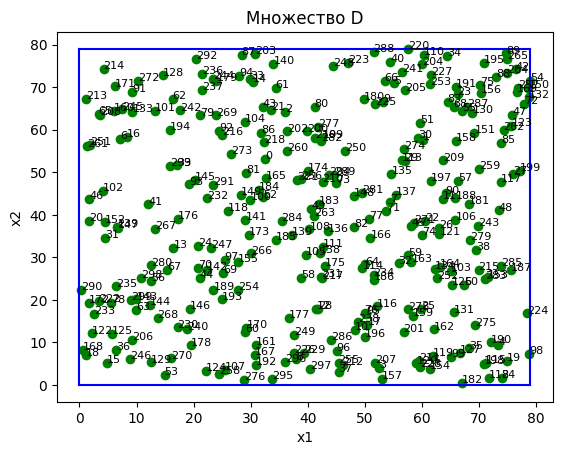

In [4]:
tochka.plot_initial_population()

## Шаг 2. Оценка приспособленности каждой тестовой точк–особи (TTO)

Для каждой пары особей в популяции сравниваются значения f1 и f2.
Если текущая особь доминирует над другой особью по обоим значениям функций, увеличивается счетчик count.

**bi** для каждой особи равен значению этого счетчика.

**fitness** для каждой особи рассчитывается на основе ее bi и общего числа особей в популяции.


In [5]:
tochka.update_fitness()


Значения признаков 			 Значения f1 и f2 			 Оценка:
+--------------------+--------------------+--------------------+--------------------+-------+--------------------+
|         x1         |         x2         |         f1         |         f2         |   b   |      fitness       |
+--------------------+--------------------+--------------------+--------------------+-------+--------------------+
| 32.506367188064935 | 53.173137297661306 | 1161.5201308228332 | 327.82195952348684 |  0.0  |        1.0         |
| 60.21096916198986  | 57.669870502471426 | 1154.3803398878763 | 625.8539595779188  |  17.0 | 0.9462025316455697 |
| 36.003879190190666 | 64.10833532388982  | 1787.5834420587953 | 163.00971671218582 |  3.0  | 0.9900662251655629 |
| 52.485227502529796 | 4.051969971287058  | 264.8251805650115  | 3840.3130429227613 |  59.0 | 0.835195530726257  |
| 73.39200922017731  | 9.355285007822161  | 92.94911112171012  | 3745.934531780193  |  25.0 | 0.9228395061728395 |
| 55.09484675901356  | 70.9

## Шаг 3. Выбор из популяции массива родителей, для скрещивания с учетом их приспособленности

Турнирная селекция предполагает случайный выбор нескольких особей из популяции и выбор наилучшей из них в качестве родителя. Этот процесс повторяется несколько раз, чтобы сформировать пары родителей для скрещивания.
Этот метод случайным образом выбирает k особей из популяции, проводит турнир и выбирает наилучшую особь, повторяя этот процесс для каждой особи в популяции. В результате он возвращает DataFrame с лучшими родителями.

In [6]:
best_parents = tochka.tournament_selection()
tochka.display_best_parents(best_parents)

Лучшие родители:
                                bkgx1                             bkgx2  \
0    11100010010111011000110000000101  01000101100111100100010001000101   
1    10001111100010010110110011001111  01111100111011001101011010111001   
2    01100110001110001101001101110101  01111001110100100011110100010110   
3    01111111000011111111010000010000  11111000000100010000110101011111   
4    00001110010010010110101100101000  10101011011001010000111110001100   
..                                ...                               ...   
295  01010000000100010111101100010001  01001011010001100101000100111110   
296  00001011011011011000001010010010  10001000111011011001110001010011   
297  11110000110111111000000111101010  11011011000001011110111010110010   
298  10110011100011010111110110011001  11001101001110000000010011101011   
299  01101011011111101101010011101011  10101011110101000110110101000010   

            x1         x2   fitness  
0    58.142234  37.364520  1.000000  
1    7

## Шаг 4. Формирование массива генотипов потомков на основе воздействия на генотипы родителей генетических операторов.

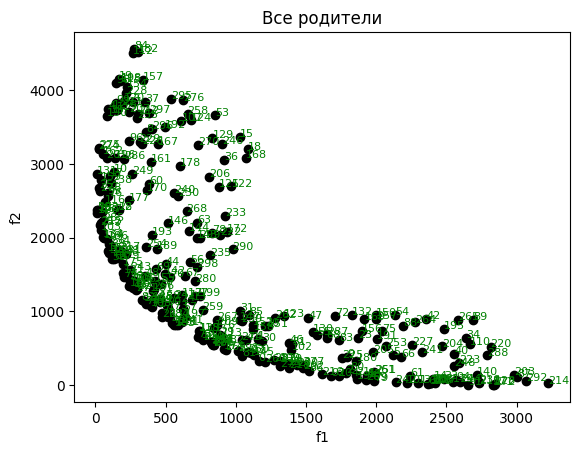

Поколение 1



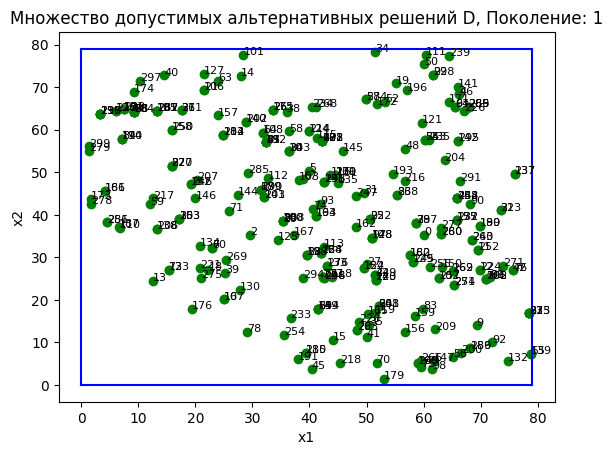

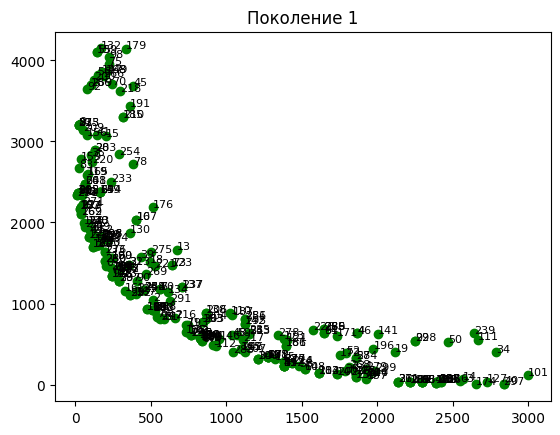

Поколение 2



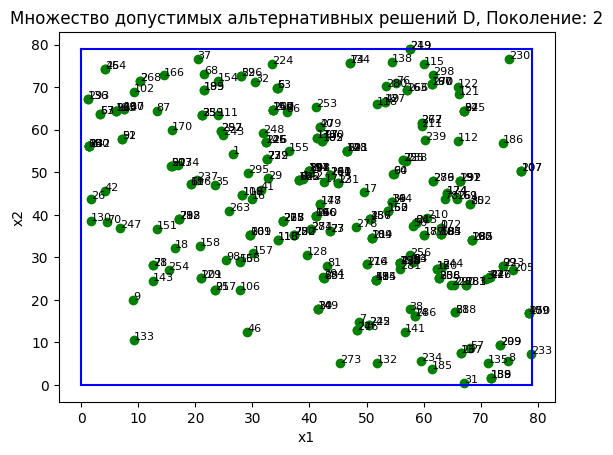

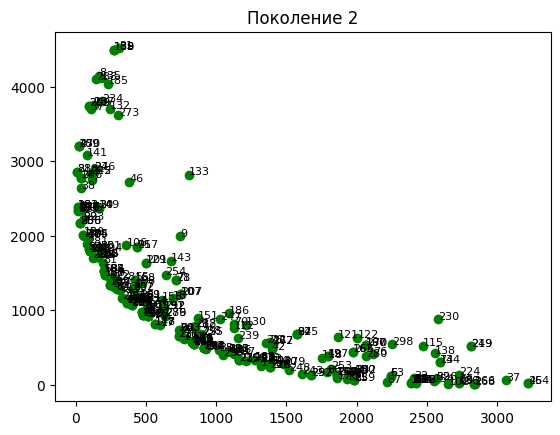

Поколение 3



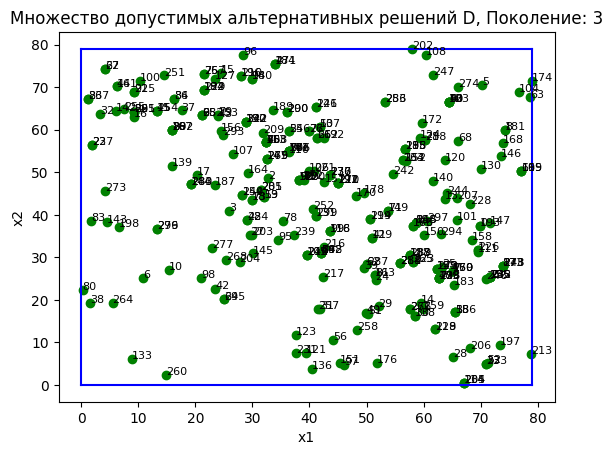

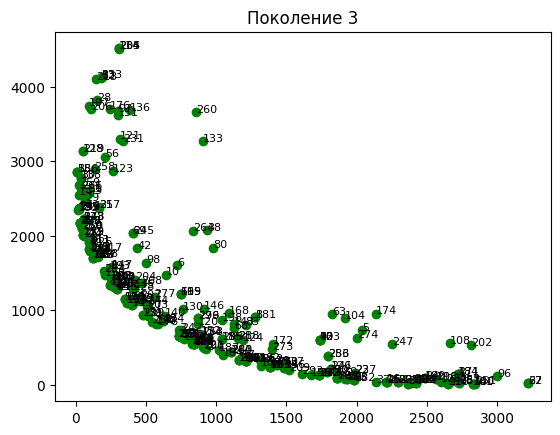

Поколение 4



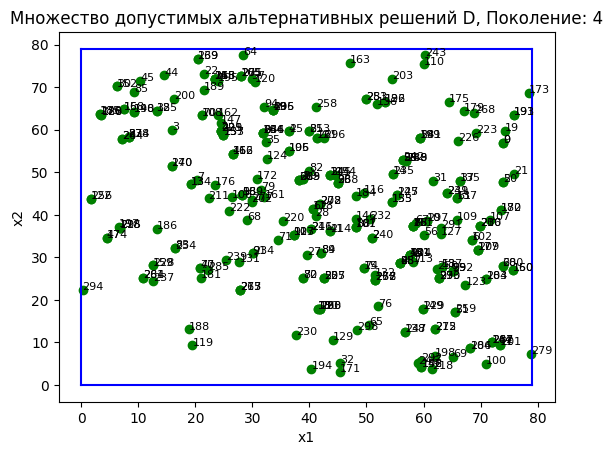

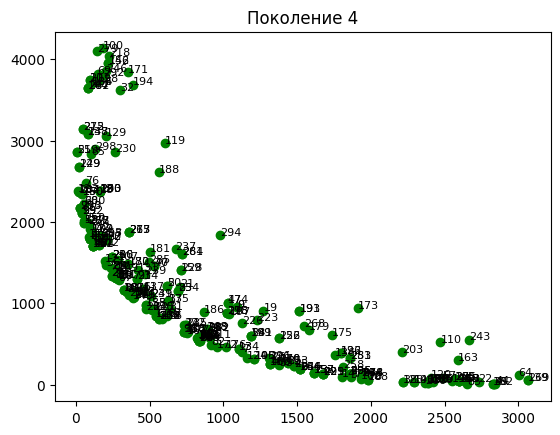

Общий массив
Empty DataFrame
Columns: [bkgx1, bkgx2, l1, l2, x1, x2, f1, f2, b, fitness]
Index: []

Сортированный массив
Empty DataFrame
Columns: [bkgx1, bkgx2, l1, l2, x1, x2, f1, f2, b, fitness]
Index: []



In [7]:
tochka.evolve()

### Получено множеством субоптимальных решений